In [1]:
import os
import sys; sys.path.insert(0, os.path.abspath("../")) 
from GenerativeModels.generative.networks.nets import VQVAE

In [9]:
from datetime import datetime
import os
import tempfile
from glob import glob
from pathlib import Path
this_path = Path().resolve()
import torch
import monai
import torchmetrics
from torch import optim, nn

import pandas as pd
import torchio as tio
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yaml

from dataset.hmri_dataset import HMRIControlsDataModule, HMRIPDDataModule
from models.pl_model import Model_AE

from typing import Optional, Sequence, Tuple, Union
from monai.networks.nets import VarAutoEncoder, AutoEncoder
from models.svae import spatialVAE
from models.pl_model import Model_AE, LossL1KLD
import torchvision.transforms.functional as F
from torchvision.utils import make_grid
plt.rcParams["savefig.bbox"] = 'tight'

In [10]:
with open('config_patches.yaml', 'r') as f:
        cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]
# modelsvae = Model_AE(**cfg['model'])

In [11]:
root_dir = Path('/mnt/scratch/7TPD/mpm_run_acu/bids/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
md_df_hc = md_df[md_df['group'] == 0]
md_df_pd = md_df[md_df['group'] == 1]

# create augmentations
augmentations = tio.Compose([])                              
cfg['aug'] = str(augmentations) # save augmentations to config file     

# create controls dataset
data = HMRIControlsDataModule(md_df=md_df_hc,
                    root_dir=root_dir,
                    augment=augmentations,
                    **cfg['dataset'])
data.prepare_data()
data.setup()

In [3]:
# net = monai.networks.nets.VarAutoEncoder(spatial_dims=3,
#                                         in_shape=[1, 128, 128, 128],      
#                                         out_channels=1,
#                                         latent_size=128,
#                                         channels=(32, 64, 128),
#                                         strides=(2, 2, 2),
#                                         norm='BATCH',
#                                         bias=False,
#                                         use_sigmoid=True)

net = spatialVAE(spatial_dims=3,
                in_shape=[1, 128, 128, 128],      
                out_channels=1,
                latent_size=128,
                channels=(32, 64, 128),
                strides=(2, 2, 2),
                norm='BATCH',
                bias=True,
                use_sigmoid=True)

strides = [2 for _ in range(len(cfg['model']['channels']))]
net2 = spatialVAE(spatial_dims=3,
                  in_shape=[cfg['model']['in_channels'], cfg['dataset']['patch_size'], cfg['dataset']['patch_size'], cfg['dataset']['patch_size']],
                  out_channels=int(cfg['model']['in_channels']),
                  latent_size=int(cfg['model']['latent_size']),
                  channels=tuple(cfg['model']['channels']),
                  strides=tuple(strides),
                  norm='BATCH',
                  bias=True,
                  use_sigmoid=True)

optimizer = torch.optim.Adam(net.parameters(), 0.001)

# BCELoss = torch.nn.BCELoss(reduction="sum")
L1Loss = torch.nn.L1Loss(reduction="sum") # 

def loss_function(recon_x, x, mu, log_var, gamma):
    l1 = L1Loss(recon_x, x)
    kld = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return gamma * l1 + (1 - gamma) * kld

lossl1kdl = LossL1KLD(gamma=0.9)

root_dir = Path('/mnt/scratch/7TPD/mpm_run_acu/bids/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
md_df_hc = md_df[md_df['group'] == 0]
md_df_pd = md_df[md_df['group'] == 1]

augmentations = tio.Compose([]) 
# create controls dataset
data = HMRIControlsDataModule(md_df=md_df_hc,
                    root_dir=root_dir,
                    augment=augmentations,
                    **cfg['dataset'])
data.prepare_data()
data.setup()
recons_imgs = data.get_images(num=4, mode='train')
print("Training:  ", len(data.train_set))
print("Validation: ", len(data.val_set))

Training:   16
Validation:  7


In [4]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [12]:
for batch in data.train_dataloader():
    inputs = batch['image'][tio.DATA]
    break
slice = 64
# inputs = inputs[..., slice]
inputs.shape

torch.Size([32, 1, 128, 128, 128])

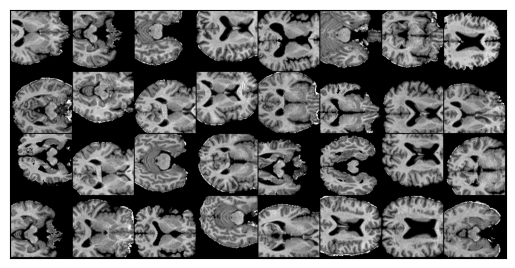

In [6]:
in_grid = make_grid(inputs[..., slice], nrow=8, normalize=True, scale_each=True)
show(in_grid)

In [7]:
modelsvae.net

spatialVAE(
  (encode): Sequential(
    (encode_0): Convolution(
      (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (adn): ADN(
        (N): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (A): PReLU(num_parameters=1)
      )
    )
    (encode_1): Convolution(
      (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (adn): ADN(
        (N): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (A): PReLU(num_parameters=1)
      )
    )
    (encode_2): Convolution(
      (conv): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (adn): ADN(
        (N): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (A): PReLU(num_parameters=1)
      )
    )
  )
  (intermediate): Identity()
  (decode): Sequential(
    (decode_0): Sequential(
      (conv): Convolution(
        (co

epoch 1, cum train loss: 86384314.0, avg train loss: 17276862.8
Inputs
Recon
epoch 1, cum test loss: 32556042.0, avg train loss: 6511208.4
epoch 2, cum train loss: 72237627.5, avg train loss: 14447525.5
epoch 3, cum train loss: 70366327.5, avg train loss: 14073265.5
epoch 4, cum train loss: 53815802.0, avg train loss: 10763160.4
epoch 5, cum train loss: 46591394.5, avg train loss: 9318278.9
epoch 6, cum train loss: 40318095.25, avg train loss: 8063619.05
Inputs
Recon
epoch 6, cum test loss: 17435814.0, avg train loss: 3487162.8
epoch 7, cum train loss: 35875964.0, avg train loss: 7175192.8
epoch 8, cum train loss: 33228440.25, avg train loss: 6645688.05
epoch 9, cum train loss: 30878770.25, avg train loss: 6175754.05
epoch 10, cum train loss: 29250287.0, avg train loss: 5850057.4
epoch 11, cum train loss: 27509066.25, avg train loss: 5501813.25
Inputs
Recon
epoch 11, cum test loss: 13177163.5, avg train loss: 2635432.7
epoch 12, cum train loss: 25920291.25, avg train loss: 5184058.25
e

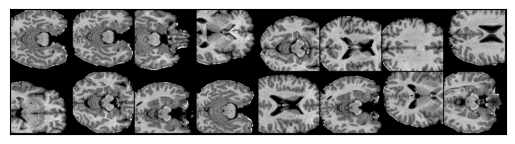

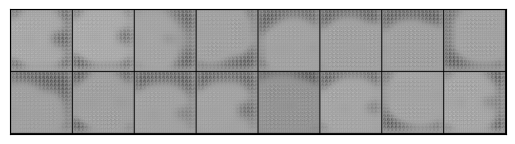

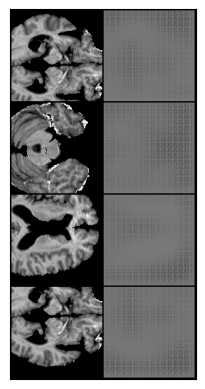

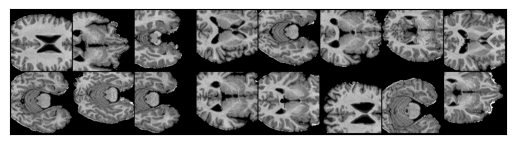

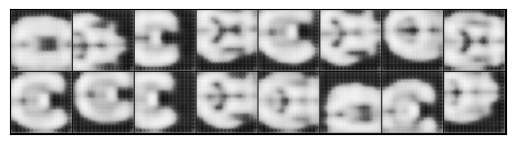

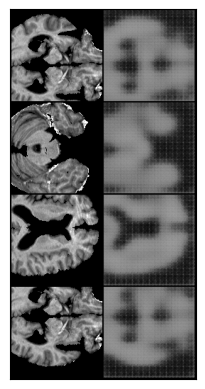

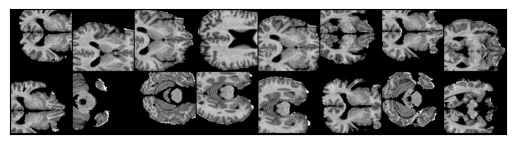

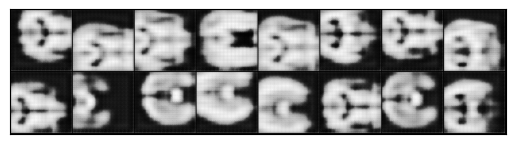

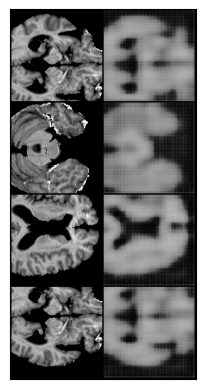

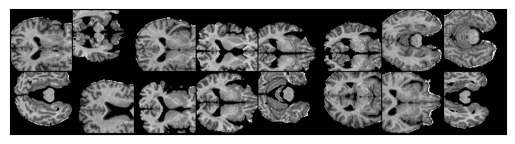

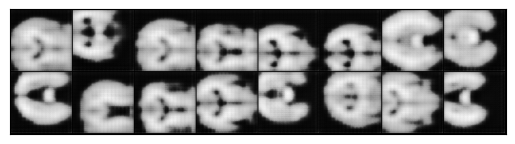

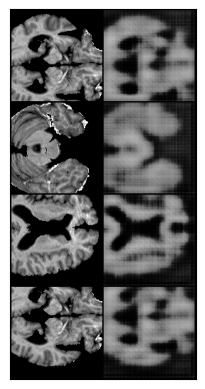

In [8]:
# usign modelsvae.net and custom loss
# 9 patches per image
model = net #modelsvae.net
device = torch.device('cpu') # "cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
every_n_epochs = 5
# t = trange(max_epochs, leave=True, desc="epoch 0, average train loss: ?, test loss: ?")
for epoch in range(20):
    model.train()
    epoch_loss = 0
    for batch_data in data.train_dataloader():
        inputs = batch_data['image'][tio.DATA].to(device)
        optimizer.zero_grad()

        recon_batch, mu, log_var, _ = model(inputs)
        loss = loss_function(recon_batch, inputs, mu, log_var, 0.9)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    # avg_train_losses.append(epoch_loss / len(train_loader.dataset))
    print(f'epoch {epoch + 1}, cum train loss: {epoch_loss }, avg train loss: {epoch_loss / 5}')
    if epoch % every_n_epochs == 0:
        print('Inputs')
        show(make_grid(inputs[..., slice].detach(), nrow=8, normalize=True, scale_each=True))
        print('Recon')
        show(make_grid(recon_batch[..., slice].detach(), nrow=8, normalize=True, scale_each=True))

    # Test
    recons_imgs.to(device)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_data in data.val_dataloader():
            inputs = batch_data['image'][tio.DATA].to(device)
            recon, mu, log_var, _ = model(inputs)
            recons_imgs_hat, _, _, _ = model(recons_imgs)
            # sum up batch loss
            test_loss += loss_function(recon, inputs, mu, log_var, 0.9).item()
    # test_loss /= len(test_loader.dataset)
    if epoch % every_n_epochs == 0:
        slices = recons_imgs.shape[-1] // 2
        imgs = torch.stack([recons_imgs[..., slices].detach(), recons_imgs_hat[..., slices].detach()], dim=1).flatten(0, 1)
        grid = make_grid(imgs, nrow=2, normalize=True, range=(-1, 1))
        show(grid)
        print(f'epoch {epoch + 1}, cum test loss: {test_loss }, avg train loss: {test_loss / 5}')


epoch 1, cum train loss: 9892366.0, avg train loss: 1978473.2
Inputs
Recon
epoch 1, cum test loss: 139.19830322265625, avg train loss: 27.83966064453125
epoch 2, cum train loss: 9734165.0, avg train loss: 1946833.0
Inputs
Recon
epoch 2, cum test loss: 154.39947509765625, avg train loss: 30.87989501953125
epoch 3, cum train loss: 9878597.0, avg train loss: 1975719.4
Inputs
Recon
epoch 3, cum test loss: 210.3509979248047, avg train loss: 42.07019958496094
epoch 4, cum train loss: 9770066.0, avg train loss: 1954013.2
Inputs
Recon
epoch 4, cum test loss: 300.4989929199219, avg train loss: 60.099798583984374


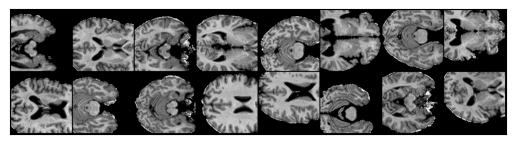

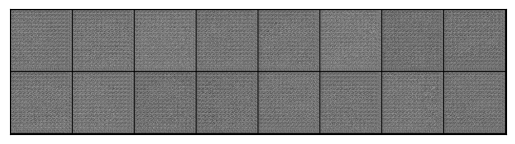

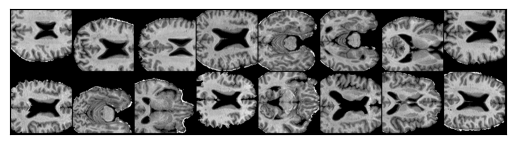

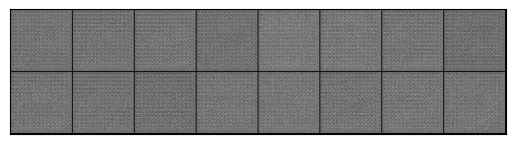

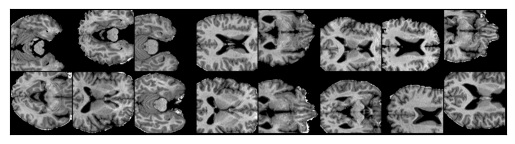

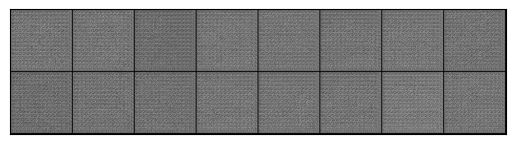

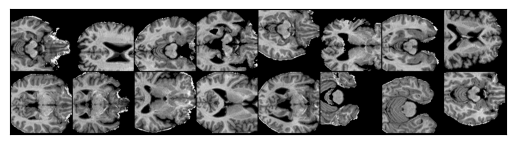

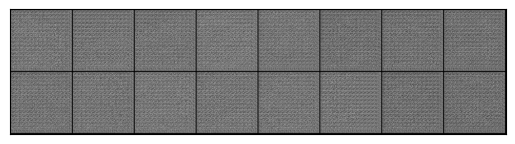

In [8]:
# using modelsvae.net and loss model class
# 9 patch per image
model = modelsvae.net
device = torch.device('cpu') # "cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
# t = trange(max_epochs, leave=True, desc="epoch 0, average train loss: ?, test loss: ?")
for epoch in range(4):
    model.train()
    epoch_loss = 0
    for batch_data in data.train_dataloader():
        inputs = batch_data['image'][tio.DATA].to(device)
        optimizer.zero_grad()

        recon_batch, mu, log_var, _ = model(inputs)
        loss = lossl1kdl(recon_batch, inputs, mu, log_var)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    # avg_train_losses.append(epoch_loss / len(train_loader.dataset))
    print(f'epoch {epoch + 1}, cum train loss: {epoch_loss }, avg train loss: {epoch_loss / 5}')
    print('Inputs')
    show(make_grid(inputs[..., slice].detach(), nrow=8, normalize=True, scale_each=True))
    print('Recon')
    show(make_grid(recon_batch[..., slice].detach(), nrow=8, normalize=True, scale_each=True))

    # Test
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_data in data.val_dataloader():
            inputs = batch_data['image'][tio.DATA].to(device)
            recon, mu, log_var, _ = model(inputs)
            # sum up batch loss
            test_loss += loss_function(recon, inputs, mu, log_var, 0.9).item()
    # test_loss /= len(test_loader.dataset)
    print(f'epoch {epoch + 1}, cum test loss: {test_loss }, avg train loss: {test_loss / 5}')


epoch 1, cum train loss: 10706869.0, avg train loss: 2141373.8
Inputs
Recon
epoch 1, cum test loss: 4174145.75, avg train loss: 834829.15
epoch 2, cum train loss: 10742655.0, avg train loss: 2148531.0
Inputs
Recon
epoch 2, cum test loss: 4239924.0, avg train loss: 847984.8
epoch 3, cum train loss: 10607990.0, avg train loss: 2121598.0
Inputs
Recon
epoch 3, cum test loss: 4079713.75, avg train loss: 815942.75
epoch 4, cum train loss: 10437076.0, avg train loss: 2087415.2
Inputs
Recon
epoch 4, cum test loss: 4075425.75, avg train loss: 815085.15


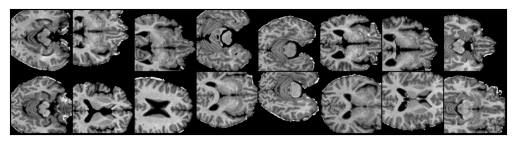

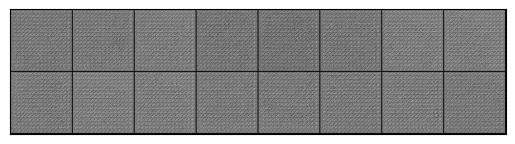

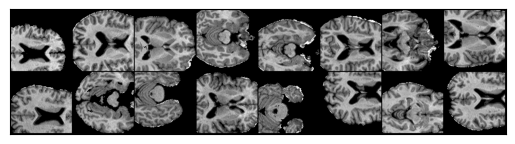

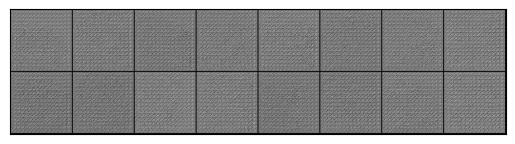

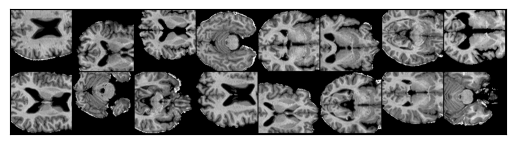

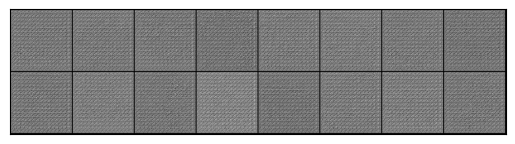

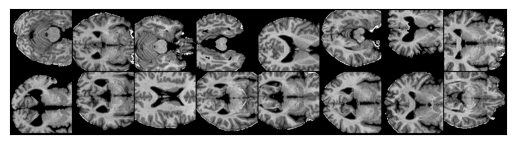

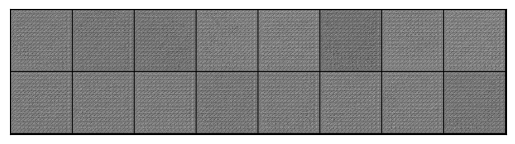

In [7]:
# using loss from model class, 1 patches per image
model = net2
device = torch.device('cpu') # "cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
# t = trange(max_epochs, leave=True, desc="epoch 0, average train loss: ?, test loss: ?")
for epoch in range(4):
    model.train()
    epoch_loss = 0
    for batch_data in data.train_dataloader():
        inputs = batch_data['image'][tio.DATA].to(device)
        optimizer.zero_grad()

        recon_batch, mu, log_var, _ = model(inputs)
        loss = lossl1kdl(recon_batch, inputs, mu, log_var)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    # avg_train_losses.append(epoch_loss / len(train_loader.dataset))
    print(f'epoch {epoch + 1}, cum train loss: {epoch_loss }, avg train loss: {epoch_loss / 5}')
    print('Inputs')
    show(make_grid(inputs[..., slice].detach(), nrow=8, normalize=True, scale_each=True))
    print('Recon')
    show(make_grid(recon_batch[..., slice].detach(), nrow=8, normalize=True, scale_each=True))

    # Test
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_data in data.val_dataloader():
            inputs = batch_data['image'][tio.DATA].to(device)
            recon, mu, log_var, _ = model(inputs)
            # sum up batch loss
            test_loss += loss_function(recon, inputs, mu, log_var, 0.9).item()
    # test_loss /= len(test_loader.dataset)
    print(f'epoch {epoch + 1}, cum test loss: {test_loss }, avg train loss: {test_loss / 5}')


epoch 1, cum train loss: 11037131.0
Inputs
Recon
epoch 1, cum test loss: 4461364.0
epoch 2, cum train loss: 10624645.0
Inputs
Recon
epoch 2, cum test loss: 4477860.0
epoch 3, cum train loss: 10028144.0
Inputs
Recon
epoch 3, cum test loss: 4264828.0
epoch 4, cum train loss: 9109068.0
Inputs
Recon
epoch 4, cum test loss: 3860986.0


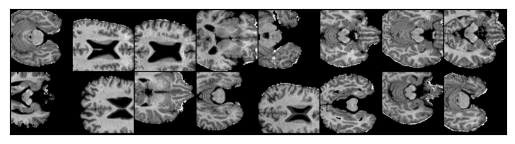

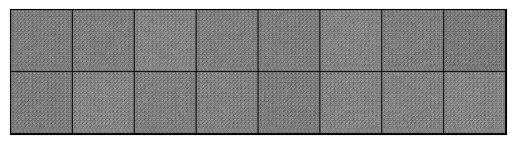

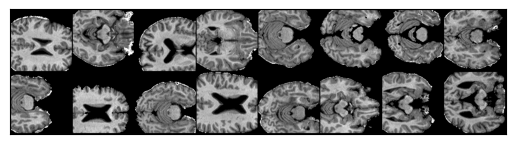

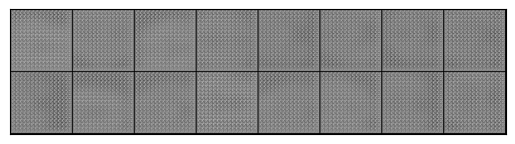

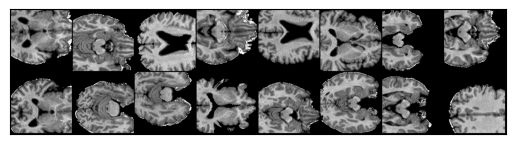

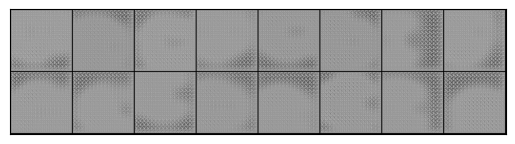

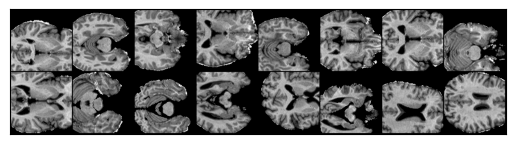

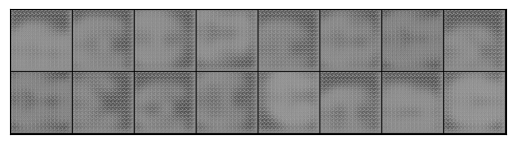

In [10]:
# custom svae and custom loss, 1 sample per image
model = net
device = torch.device('cpu') # "cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
# t = trange(max_epochs, leave=True, desc="epoch 0, average train loss: ?, test loss: ?")
for epoch in range(4):
    model.train()
    epoch_loss = 0
    for batch_data in data.train_dataloader():
        inputs = batch_data['image'][tio.DATA].to(device)
        optimizer.zero_grad()

        recon_batch, mu, log_var, _ = model(inputs)
        loss = loss_function(recon_batch, inputs, mu, log_var, 0.9)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    # avg_train_losses.append(epoch_loss / len(train_loader.dataset))
    print(f'epoch {epoch + 1}, cum train loss: {epoch_loss }')
    print('Inputs')
    show(make_grid(inputs[..., slice].detach(), nrow=8, normalize=True, scale_each=True))
    print('Recon')
    show(make_grid(recon_batch[..., slice].detach(), nrow=8, normalize=True, scale_each=True))

    # Test
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_data in data.val_dataloader():
            inputs = batch_data['image'][tio.DATA].to(device)
            recon, mu, log_var, _ = model(inputs)
            # sum up batch loss
            test_loss += loss_function(recon, inputs, mu, log_var, 0.9).item()
    # test_loss /= len(test_loader.dataset)
    print(f'epoch {epoch + 1}, cum test loss: {test_loss }')


#### dev

In [28]:
net_svae = spatialVAE(spatial_dims=3, 
                      in_shape=[1, 64, 64, 64],
                      out_channels=1, 
                      latent_size=32, 
                      channels=[32, 64, 128, 256], 
                      strides=[2, 2, 2, 2],
                      norm='BATCH',
                      bias=True,
                      use_sigmoid=True)
net_svae

spatialVAE(
  (encode): Sequential(
    (encode_0): Convolution(
      (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (adn): ADN(
        (N): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (A): PReLU(num_parameters=1)
      )
    )
    (encode_1): Convolution(
      (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (adn): ADN(
        (N): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (A): PReLU(num_parameters=1)
      )
    )
    (encode_2): Convolution(
      (conv): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (adn): ADN(
        (N): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (A): PReLU(num_parameters=1)
      )
    )
    (encode_3): Convolution(
      (conv): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
   

In [29]:
svae_inputs = torch.randn(1, 1, 64, 64, 64)
svae_out, mu, logvar, z = net_svae(svae_inputs)

In [30]:
svae_out.shape, mu.shape, logvar.shape, z.shape

(torch.Size([1, 1, 64, 64, 64]),
 torch.Size([1, 32, 4, 4, 4]),
 torch.Size([1, 32, 4, 4, 4]),
 torch.Size([1, 32, 4, 4, 4]))

In [13]:
net = monai.networks.nets.VarAutoEncoder(spatial_dims=3,
                                        in_shape=[1, 64, 64, 64],      
                                        out_channels=1,
                                        latent_size=128,
                                        channels=(32, 64, 128),
                                        strides=(2, 2, 2),
                                        norm='BATCH',
                                        bias=False,
                                        use_sigmoid=True)
# add activation to the last layer
# net.decode[-1].conv.add_module('adn', monai.networks.blocks.ADN('NDA', 1, act='sigmoid'))
net

VarAutoEncoder(
  (encode): Sequential(
    (encode_0): Convolution(
      (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (adn): ADN(
        (N): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (A): PReLU(num_parameters=1)
      )
    )
    (encode_1): Convolution(
      (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (adn): ADN(
        (N): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (A): PReLU(num_parameters=1)
      )
    )
    (encode_2): Convolution(
      (conv): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (adn): ADN(
        (N): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (A): PReLU(num_parameters=1)
      )
    )
  )
  (intermediate): Identity()
  (decode): Sequential(
    (decode_0): Sequential

In [21]:
net = monai.networks.nets.AutoEncoder(spatial_dims=3,
                                        in_channels=1,      
                                        out_channels=1,
                                        channels=(32, 64, 128, 256),
                                        strides=(2, 2, 2, 2),
                                        norm='BATCH',
                                        bias=False)
net

AutoEncoder(
  (encode): Sequential(
    (encode_0): Convolution(
      (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (adn): ADN(
        (N): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (A): PReLU(num_parameters=1)
      )
    )
    (encode_1): Convolution(
      (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (adn): ADN(
        (N): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (A): PReLU(num_parameters=1)
      )
    )
    (encode_2): Convolution(
      (conv): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (adn): ADN(
        (N): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (A): PReLU(num_parameters=1)
      )
    )
    (encode_3): Convolution(
      (conv): Conv3d(128, 256, kernel_size=(3, 3, 3), str

In [7]:
net.decode.decode_2.conv.add_module('adn', monai.networks.blocks.ADN('NDA', 1, act='sigmoid'))

In [2]:
root_dir = Path('/mnt/scratch/7TPD/mpm_run_acu/bids/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
md_df_hc = md_df[md_df['group'] == 0]
md_df_pd = md_df[md_df['group'] == 1]
# (md_df_hc)

In [7]:
# root_dir = Path('/mnt/scratch/7TPD/mpm_run_acu/bids/derivatives/hMRI')
# subj_dir = root_dir / md_df_hc['id'][0] / 'Results'
# lists = sorted(list(subj_dir.glob('*w_masked.nii')), key=lambda x: x.stem)
# maps = ['MTsat', 'R1']
# lists = [x for x in lists if any(sub in x.stem for sub in maps)]

In [3]:
with open('config_patches.yaml', 'r') as f:
        cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]

augmentations = tio.Compose([])

# data = HMRIControlsDataModule(md_df=md_df_hc,
#                         root_dir=root_dir,
#                         augment=augmentations,
#                         **cfg['dataset'])
data = HMRIPDDataModule(md_df=md_df_pd,
                        root_dir=root_dir,
                        augment=augmentations,
                        **cfg['dataset'])
data.prepare_data()
data.setup()

Drop subjects ['sub-058', 'sub-016', 'sub-025']


/home/alejandrocu/Documents/parkinson_classification/dataset/hmri_dataset.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.md_df.drop(self.md_df[self.md_df.id == drop_id].index, inplace=True)


In [14]:
subject = data.dataset[0]
sampler = tio.data.GridSampler(subject, patch_size=(64, 64, 64),
                                patch_overlap=0,
                                padding_mode='minimum')
samples = [patch for patch in sampler(subject)]
patches = torch.stack([sample['image'][tio.DATA] for sample in samples])
locations = torch.stack([sample[tio.LOCATION] for sample in samples])
# sampler.subject

In [17]:
locations.shape

torch.Size([27, 6])

In [20]:
aggregator = tio.data.GridAggregator(sampler)
aggregator.add_batch(patches, locations)
reconstructed = aggregator.get_output_tensor()

In [24]:
reconstructed.shape

torch.Size([1, 180, 180, 180])

In [26]:
diff = [reconstructed for _ in range(4)]
torch.sum(torch.stack(diff), dim=0).shape

torch.Size([1, 180, 180, 180])

In [23]:
og_img = subject['image'][tio.DATA]
diff = [torch.pow(og_img[i] - reconstructed[i], 2) for i in range(og_img.shape[0])]
rerror = torch.sqrt(torch.sum(torch.stack(diff), dim=0))
torch.mean(rerror)

tensor(0.)

In [4]:
dl = data.train_dataloader()
for batch in dl:
    inputs = batch['image'][tio.DATA]
    break
print(inputs.shape)

torch.Size([9, 1, 64, 64, 64])


In [5]:
patches = data.get_images(4)

In [13]:
patches.shape[-1] //2

32

In [11]:
torch.stack([patches[..., 32], patches[..., 32]], dim=1).flatten(0, 1).shape

torch.Size([8, 1, 64, 64])

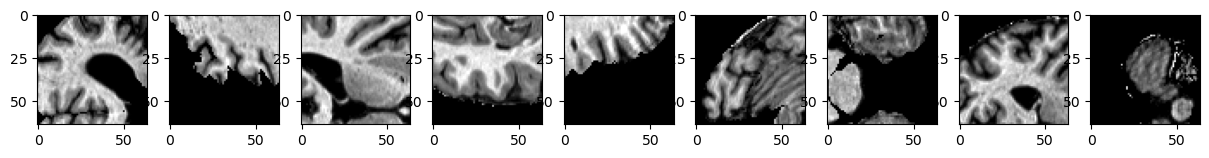

In [6]:
f,axs = plt.subplots(1,inputs.shape[0], figsize=(15, 3))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(inputs[i].cpu().detach().numpy()[0, :, :, 32], cmap='gray')

In [16]:
loss = nn.MSELoss() #reduction='none') # nn.functional.mse_loss
input = torch.randn(9, 1, 32, 32, 32)
target = torch.randn(9, 1, 32, 32, 32)
output = loss(input, target)
output.shape

torch.Size([])

In [22]:
output = net.encode(inputs)
output.shape

torch.Size([9, 256, 4, 4, 4])

In [4]:
from models.pl_model import Model_AE
model = Model_AE(net='autoencoder', **cfg['model'])
model.net

/home/alejandrocu/Documents/parkinson_classification/models/medicalnet


AutoEncoder(
  (encode): Sequential(
    (encode_0): Convolution(
      (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (adn): ADN(
        (N): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (A): PReLU(num_parameters=1)
      )
    )
    (encode_1): Convolution(
      (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (adn): ADN(
        (N): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (A): PReLU(num_parameters=1)
      )
    )
    (encode_2): Convolution(
      (conv): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (adn): ADN(
        (N): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (A): PReLU(num_parameters=1)
      )
    )
    (encode_3): Convolution(
      (conv): Conv3d(128, 256, kernel_size=(3, 3, 3), str

In [7]:
model.criterion

L1Loss()